In [17]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk

# >>> sæt denne til mappen med snips for en patient / et event
EVENT_DIR = Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results_Excluded_seizures_removed\Responders\Patient 5\recording 1")

# hvilke metoder sammenlignes
METHODS = ["raw", "jeppesen", "neurokit", "elgendi2010", "pantompkins1985"]

# fælles fs (hvis dine snips allerede er i samme fs); ellers returnér fs pr. snip i loaderen
FS_DEFAULT = 512
OUTDIR = Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results_Excluded_seizures_removed\Results\Patient 5")
OUTDIR.mkdir(exist_ok=True, parents=True)


In [18]:
from pathlib import Path
import numpy as np
import pandas as pd

DATA_EXTS = (".csv", ".txt", ".tsv")

def find_data_file(event_dir: Path, stem: str) -> Path:
    cands = [p for p in event_dir.iterdir()
             if p.stem == stem and p.suffix.lower() in DATA_EXTS]
    if not cands:
        raise FileNotFoundError(f"Ingen datafil fundet for '{stem}'. Forventede {DATA_EXTS}.")
    # hvis der er flere, vælg .csv først
    cands.sort(key=lambda p: (p.suffix.lower() != ".csv", p.suffix.lower()))
    return cands[0]

def read_signal_file(path: Path, fs_default: float):
    """
    Forsøger at læse 1-2 kolonner:
      - 1 kolonne => ren signalserie
      - 2 kolonner => [tid, signal]; fs estimeres fra tidskolonne
    Håndterer , ; \\t + decimal-komma/punktum.
    """
    # prøv et par kodninger (Windows/UTF-8)
    encodings = ["utf-8", "cp1252", "latin1"]
    seps = [",", ";", "\t", None]  # None = pandas auto-sniffer (engine='python')

    last_err = None
    for enc in encodings:
        for sep in seps:
            try:
                df = pd.read_csv(path, sep=sep, engine="python", encoding=enc)
                break
            except Exception as e:
                last_err = e
                df = None
        if df is not None:
            break
    if df is None:
        raise last_err

    # decimal-komma håndtering: prøv at konvertere alt numerisk
    df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", "."), errors="coerce"))
    df = df.dropna(axis=1, how="all").dropna(axis=0, how="all")

    if df.shape[1] == 1:
        sig = df.iloc[:,0].to_numpy(dtype=float)
        fs = float(fs_default)
        t = np.arange(len(sig)) / fs
    else:
        t_raw = df.iloc[:,0].to_numpy(dtype=float)
        sig = df.iloc[:,1].to_numpy(dtype=float)
        # estimer fs fra tid (robust median-dt)
        dt = np.median(np.diff(t_raw))
        fs = float(1.0/dt) if dt > 0 else float(fs_default)
        t = t_raw

    return {"sig": sig, "fs": fs, "t": t, "path": path}


In [19]:
def load_event_snips(event_dir: Path, fs_default=FS_DEFAULT):
    out = {}
    for key, stem in [
        ("seizure_only", "event01_seizure_only"),
        ("seizure_ctx",  "event01_seizure_ctx"),
        ("nonseizure",   "event01_nonseizure"),
        # ("sanity",       "event01_sanity"),
    ]:
        try:
            p = find_data_file(event_dir, stem)
            out[key] = read_signal_file(p, fs_default)
        except FileNotFoundError as e:
            print(f"[INFO] {e}")
    return out

snips = load_event_snips(EVENT_DIR)
if not snips:
    raise RuntimeError(f"Ingen snips fundet i {EVENT_DIR}. Tjek filnavne/stier.")
print({k: (len(v['sig']), v['fs']) for k,v in snips.items()})

{'seizure_only': (61440, 512.0), 'seizure_ctx': (184320, 512.0), 'nonseizure': (184320, 512.0)}


In [20]:
# --- Jeppesen (importér din funktion hvis den ligger i modul) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Dict, Any, Tuple
from scipy.signal import remez, filtfilt

FS_TARGET = 256.0  # hvis du vil resample snips til fælles fs; ellers brug deres egne fs

## Dublet from Jeppesen_enhancement_Validation
# -------- helper: 8-point moving average (med spejl-padding for pæn kant) --------
def _moving_average_8(x: np.ndarray) -> np.ndarray:
    w = 8
    if len(x) < w + 2:
        return x.copy()
    kernel = np.ones(w, dtype=float) / w
    pad = w
    xpad = np.r_[x[pad:0:-1], x, x[-2:-pad-2:-1]]
    y = np.convolve(xpad, kernel, mode="same")[pad:-pad]
    return y

# -------- helper: konservativt kanttrim pga. filtfilt + FIR --------
def _edge_trim_seconds(fs: float, taps_hp: int, taps_lp: int, smooth_len: int = 8) -> float:
    # filtfilt fordobler den effektive kant; læg lille sikkerhed på
    half_hp = (taps_hp - 1) / 2
    half_lp = (taps_lp - 1) / 2
    half_sm = (smooth_len - 1) / 2
    edge_samples = int(np.ceil((half_hp + half_lp + half_sm) * 2 * 1.2))
    return edge_samples / fs

@dataclass
class JeppesenParams:
    sampling_rate: float = 512.0  # ePatch
    # Equiripple højpas (HP): stop 0–1 Hz, pass fra 30 Hz, 33 taps (ordre 32)
    hp_stop_hz: float = 1.0
    hp_pass_hz: float = 30.0
    taps_hp: int = 33
    # Equiripple lavpas (LP): pass 0–32 Hz, stop fra 50 Hz, 32 taps (ordre 31)
    lp_pass_hz: float = 32.0
    lp_stop_hz: float = 50.0
    taps_lp: int = 32
    # Efterbehandling
    use_smoothing: bool = True     # 8-punkts glidende middel
    # Kanttrim i plots/analyse (påvirker ikke selve filtreringen)
    edge_trim_s: Optional[float] = None  # None => auto baseret på taps

def ecg_clean_jeppesen(signal: np.ndarray,
                       sampling_rate: Optional[float] = None,
                       return_all: bool = False,
                       params: Optional[JeppesenParams] = None
                       ) -> np.ndarray | Dict[str, Any]:
    """
    Jeppesen et al. (IEEE, 2017) ECG 'filtering/enhancement' pipeline:
        1) Equi-ripple FIR high-pass: stop 0–1 Hz, pass >= 30 Hz, 33 taps
        2) Equi-ripple FIR low-pass: pass 0–32 Hz, stop >= 50 Hz, 32 taps
        3) 8-point moving average smoothing
    Ingen absolutværdi før R-peak-detektion.

    Parameters
    ----------
    signal : array
        Rå ECG.
    sampling_rate : float, optional
        Hz. Default hentes fra params (512 Hz).
    return_all : bool
        True => returnér dict med mellemtrin og meta.
    params : JeppesenParams
        Finjusteringer (taps, grænser, edge trim m.m.)

    Returns
    -------
    cleaned : array (eller dict hvis return_all=True)
    """
    x = np.asarray(signal, dtype=float)
    p = params or JeppesenParams()
    fs = float(sampling_rate if sampling_rate is not None else p.sampling_rate)

    # --- High-pass (equiripple) ---
    # Bands: [0, hp_stop] -> 0  |  [hp_pass, fs/2] -> 1
    # Brug højere weight i stopbåndet for bedre baseline-afvisning.
    bands_hp = [0.0, p.hp_stop_hz, p.hp_pass_hz, fs/2.0]
    desired_hp = [0, 1]
    weights_hp = [3, 1]  # prioriter baseline-fjernelse
    bhp = remez(p.taps_hp, bands_hp, desired_hp, weight=weights_hp, fs=fs)
    x_hp = filtfilt(bhp, [1.0], x)

    # --- Low-pass (equiripple) ---
    # Bands: [0, lp_pass] -> 1  |  [lp_stop, fs/2] -> 0
    bands_lp = [0.0, p.lp_pass_hz, p.lp_stop_hz, fs/2.0]
    desired_lp = [1, 0]
    weights_lp = [1, 3]  # prioriter stop over 50 Hz
    blp = remez(p.taps_lp, bands_lp, desired_lp, weight=weights_lp, fs=fs)
    x_lp = filtfilt(blp, [1.0], x_hp)

    # --- 8-point smoothing (valgfrit) ---
    x_sm = _moving_average_8(x_lp) if p.use_smoothing else x_lp

    # --- edge trim (til sammenlignelige plots/analyser) ---
    edge_s = p.edge_trim_s if p.edge_trim_s is not None else _edge_trim_seconds(fs, p.taps_hp, p.taps_lp, 8)
    k = int(round(edge_s * fs))
    if k > 0 and (len(x_sm) > 2*k):
        # Trimmer kun til QA/plot – selve filtreringen er fuld længde
        trimmed = x_sm[k:-k].copy()
    else:
        trimmed = x_sm.copy()

    if not return_all:
        return trimmed

    return {
        "cleaned": trimmed,
        "hp": x_hp,
        "lp": x_lp,
        "smoothed": x_sm,
        "fs": fs,
        "filters": {"bhp": bhp, "blp": blp},
        "edge_trim_s": edge_s
    }



In [21]:
from scipy.signal import welch

def spectral_metrics(sig, fs):
    nperseg = min(4096, len(sig))
    f, Pxx = welch(sig, fs=fs, nperseg=nperseg)
    def bp(f1,f2):
        m = (f>=f1)&(f<=f2)
        return np.trapz(Pxx[m], f[m]) if np.any(m) else 0.0
    p_in  = bp(0.5,40.0)
    p_hi  = bp(40.0,fs/2)
    p_base= bp(0.0,0.5)
    return {
        "spec_snr": p_in/(p_hi+1e-12),
        "baseline_ratio": p_base/(p_in+1e-12)
    }

# ---------- SQI (0..1) ----------
from scipy.signal import welch

def _band_power_welch(sig, fs, f1, f2, nperseg=None):
    nperseg = nperseg or min(4096, len(sig))
    if nperseg < 8:
        return np.nan
    f, Pxx = welch(sig, fs=fs, nperseg=nperseg)
    m = (f >= f1) & (f <= f2)
    if not np.any(m): 
        return 0.0
    return np.trapz(Pxx[m], f[m])

def _flatline_pct(sig, eps=None):
    s = np.std(sig)
    eps = eps or (1e-9 + 1e-6 * s)
    d = np.abs(np.diff(sig))
    return 100.0 * np.mean(d < eps)

def _clipping_pct(sig, q=0.001, tol=0.0):
    lo = np.quantile(sig, q); hi = np.quantile(sig, 1-q)
    return 100.0 * (np.mean(sig <= lo + tol) + np.mean(sig >= hi - tol))

def _zscore(x, lo, hi):
    if np.isnan(x) or lo == hi: return 0.0
    return float(np.clip((x - lo) / (hi - lo), 0.0, 1.0))

def _invscore(x, lo, hi):  # lavt er godt
    return 1.0 - _zscore(x, lo, hi)

def ecg_sqi(signal, fs, bands=(0.5,40.0), high_band=(40.0,None), baseline_band=(0.0,0.5),
            line_band=(49.0,51.0), weights=None, return_dict=True):
    x = np.asarray(signal, float)
    f_lo, f_hi = bands
    f_hi_high = fs/2.0 if high_band[1] is None else high_band[1]
    p_in  = _band_power_welch(x, fs, f_lo, f_hi)
    p_hi  = _band_power_welch(x, fs, high_band[0], f_hi_high)
    p_base= _band_power_welch(x, fs, baseline_band[0], baseline_band[1])
    p_line= _band_power_welch(x, fs, line_band[0], line_band[1])

    spec_snr       = p_in/(p_hi+1e-12)
    baseline_ratio = p_base/(p_in+1e-12)
    line_ratio     = p_line/(p_in+1e-12)
    flat_pct       = _flatline_pct(x)
    clip_pct       = _clipping_pct(x)

    sc_snr  = _zscore(np.log10(spec_snr + 1e-12), lo=0.0,  hi=3.0)
    sc_base = _invscore(baseline_ratio,            lo=0.00, hi=0.05)
    sc_line = _invscore(line_ratio,                lo=0.00, hi=0.02)
    sc_flat = _invscore(flat_pct/100.0,            lo=0.00, hi=0.01)
    sc_clip = _invscore(clip_pct/100.0,            lo=0.00, hi=0.005)

    comps = {"SNR":sc_snr, "Baseline":sc_base, "LineNoise":sc_line, "Flatline":sc_flat, "Clipping":sc_clip}
    weights = weights or {"SNR":0.40, "Baseline":0.20, "LineNoise":0.15, "Flatline":0.15, "Clipping":0.10}
    wsum = sum(weights[k] for k in comps)
    score = float(sum(weights[k]*comps[k] for k in comps) / wsum)

    if not return_dict:
        return score
    return {"score":score, "components":comps,
            "metrics":{"spec_snr":spec_snr,"baseline_ratio":baseline_ratio,"line_ratio":line_ratio,
                       "flatline_pct":flat_pct,"clipping_pct":clip_pct}}


# ---------- Segmenteret SQI -> pr-sample ----------
def _segments(n, fs, window_s=10.0, step_s=2.0):
    w = int(round(window_s*fs)); s = int(round(step_s*fs))
    if w <= 1: return [(0,n)]
    edges=[]; i0=0
    while i0 < n:
        i1=min(n, i0+w); edges.append((i0,i1))
        if i1==n: break
        i0 += s
    return edges

def ecg_sqi_segmented(signal, fs, window_s=10.0, step_s=2.0,
                      weights=None, line_band=(49.0,51.0),
                      aggregate="mean", return_details=True):
    x = np.asarray(signal, float)
    n = len(x)
    segs = _segments(n, fs, window_s, step_s)
    sqi_samples = np.zeros(n); counts = np.zeros(n, dtype=int)
    rows=[]
    for i0,i1 in segs:
        out = ecg_sqi(x[i0:i1], fs, line_band=line_band, weights=weights, return_dict=True)
        sc = out["score"]
        if aggregate == "max":
            sqi_samples[i0:i1] = np.maximum(sqi_samples[i0:i1], sc); counts[i0:i1] = np.maximum(counts[i0:i1],1)
        elif aggregate == "last":
            sqi_samples[i0:i1] = sc; counts[i0:i1] = 1
        else:
            sqi_samples[i0:i1] += sc; counts[i0:i1] += 1
        rows.append({"start_s":i0/fs, "end_s":i1/fs, "center_s":(i0+i1)/(2*fs), "SQI":sc, **out["metrics"]})
    if aggregate == "mean":
        counts[counts==0]=1; sqi_samples = sqi_samples / counts
    df = pd.DataFrame(rows) if return_details else None
    return (sqi_samples, df) if return_details else sqi_samples


In [22]:
def analyze_snip(name, snip):
    x = snip["sig"]
    fs = snip["fs"]

    # Jeppesen filtering/enhancement
    xj = ecg_clean_jeppesen(x, sampling_rate=fs)

    # Segmenteret SQI (10s vinduer, 2s step) på det filtrerede signal
    sqi_samples, df_seg = ecg_sqi_segmented(xj, fs, window_s=10, step_s=2)
    sqi_mean = float(np.nanmean(sqi_samples))
    sqi_median = float(np.nanmedian(sqi_samples))

    # Globale spektrale mål (samme som du brugte)
    out_global = ecg_sqi(xj, fs, return_dict=True)
    spec_snr = out_global["metrics"]["spec_snr"]
    base_ratio = out_global["metrics"]["baseline_ratio"]
    line_ratio = out_global["metrics"]["line_ratio"]

    # pak resultater
    return {
        "name": name,
        "fs": fs,
        "N": len(x),
        "SQI_mean": sqi_mean,
        "SQI_median": sqi_median,
        "spec_snr": spec_snr,
        "baseline_ratio": base_ratio,
        "line_ratio": line_ratio,
        "df_segments": df_seg,
        "filtered": xj,
        "raw": x,
    }

results = [analyze_snip(k, v) for k,v in snips.items()]
df_summary = pd.DataFrame([{k:v for k,v in r.items() if not isinstance(v, (pd.DataFrame, np.ndarray))} for r in results])
df_summary.set_index("name").sort_index()


,fs,N,SQI_mean,SQI_median,spec_snr,baseline_ratio,line_ratio
name,,,,,,,
nonseizure,512.0,184320,0.951136,0.951367,19925.656607,1.798662e-06,1.027189e-09
seizure_ctx,512.0,184320,0.952312,0.953103,12931.616373,1.485339e-06,1.566386e-09
seizure_only,512.0,61440,0.952859,0.953122,10330.746716,7.364215e-07,1.942218e-09


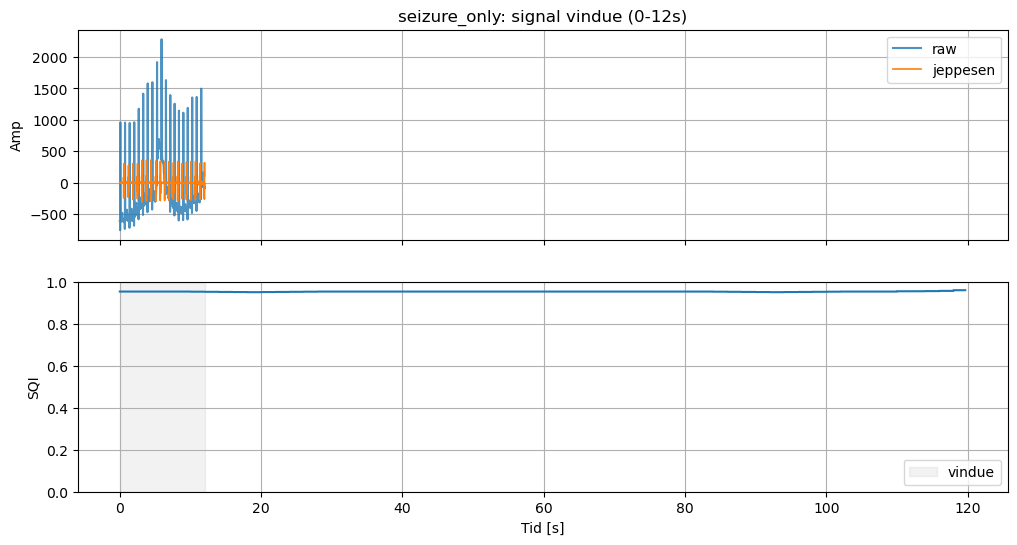

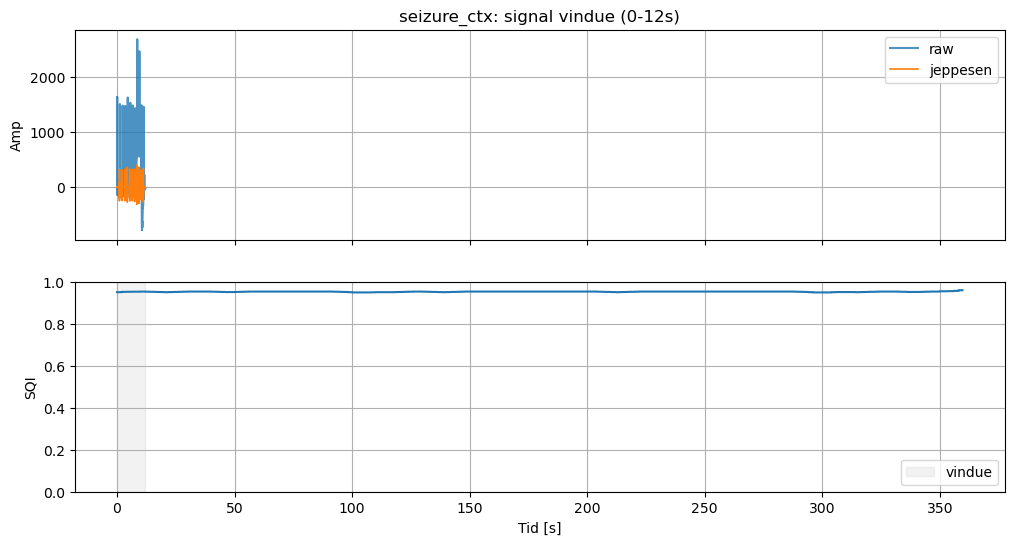

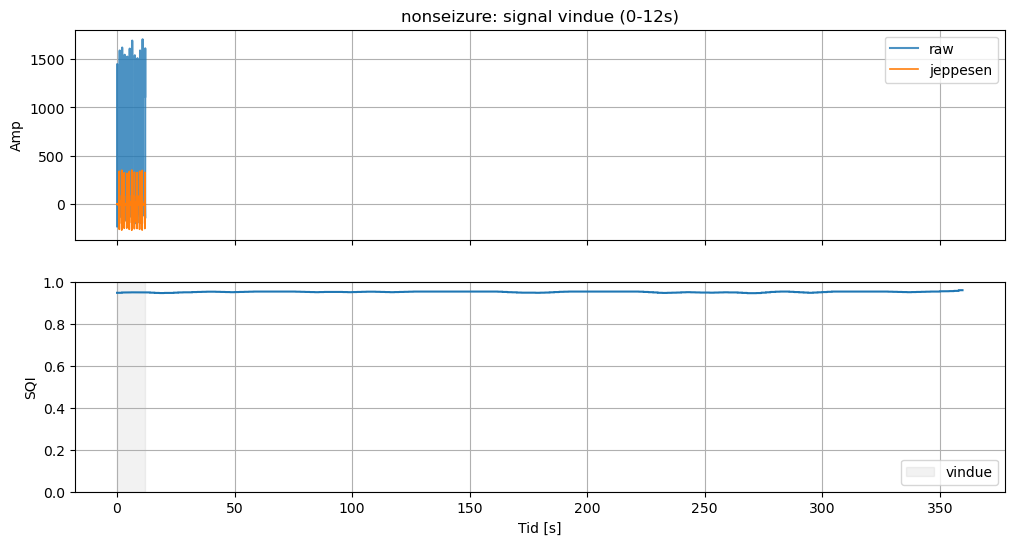

In [23]:
def plot_snip_overview(res, start_s=0, dur_s=10):
    name = res["name"]; fs = res["fs"]
    x_raw = res["raw"]; x_f = res["filtered"]
    t = np.arange(len(x_raw))/fs

    # vindue
    i0 = int(start_s*fs); i1 = i0 + int(dur_s*fs)
    i1 = min(i1, len(x_raw))

    fig, axs = plt.subplots(2,1, figsize=(12,6), sharex=True)
    axs[0].plot(t[i0:i1], x_raw[i0:i1], label="raw", alpha=0.8)
    axs[0].plot(t[i0:i1], x_f[i0:i1], label="jeppesen", linewidth=1.2)
    axs[0].set_title(f"{name}: signal vindue ({start_s}-{start_s+dur_s}s)")
    axs[0].set_ylabel("Amp"); axs[0].grid(True); axs[0].legend()

    # SQI tidsserie
    sqi_samples, df_seg = ecg_sqi_segmented(x_f, fs, window_s=10, step_s=2)
    tt = np.arange(len(sqi_samples))/fs
    axs[1].plot(tt, sqi_samples)
    axs[1].axvspan(start_s, start_s+dur_s, color="k", alpha=0.05, label="vindue")
    axs[1].set_ylim(0,1); axs[1].set_ylabel("SQI"); axs[1].set_xlabel("Tid [s]"); axs[1].grid(True); axs[1].legend()
    plt.show()

for res in results:
    plot_snip_overview(res, start_s=0, dur_s=12)


,SQI_mean,SQI_median,spec_snr,baseline_ratio,line_ratio
name,,,,,
seizure_only,0.952859,0.953122,10330.746716,7.364215e-07,1.942218e-09
seizure_ctx,0.952312,0.953103,12931.616373,1.485339e-06,1.566386e-09
nonseizure,0.951136,0.951367,19925.656607,1.798662e-06,1.027189e-09


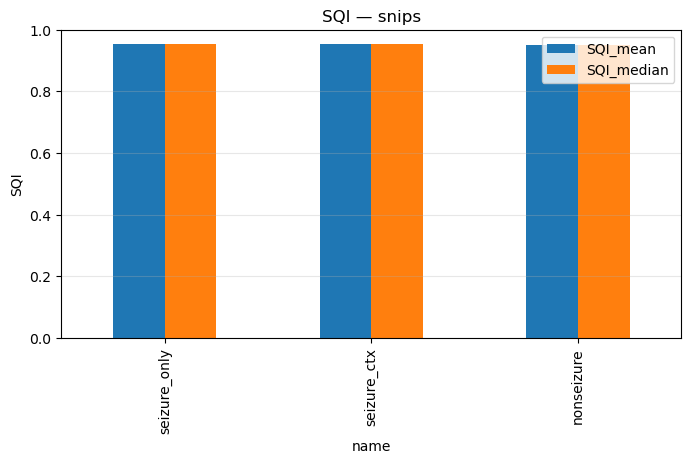

In [24]:
want = ["seizure_only","seizure_ctx","nonseizure"]
df_cmp = df_summary[df_summary["name"].isin(want)].set_index("name")[["SQI_mean","SQI_median","spec_snr","baseline_ratio","line_ratio"]]
display(df_cmp)

ax = df_cmp[["SQI_mean","SQI_median"]].plot.bar(figsize=(8,4), title="SQI — snips", ylim=(0,1))
ax.grid(True, axis="y", alpha=0.3); ax.set_ylabel("SQI")
plt.show()


In [25]:
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy.stats import kurtosis, skew

# — allerede defineret tidligere: ecg_sqi, ecg_sqi_segmented, _band_power_welch, _flatline_pct, _clipping_pct —

def quality_metrics(signal: np.ndarray, fs: float) -> dict:
    """Samlet pakke af robuste, forklarlige mål for ét (allerede valgt) signal."""
    x = np.asarray(signal, float)

    # Spektrale mål (samme bånd som tidligere)
    p_in   = _band_power_welch(x, fs, 0.5, 40.0)
    p_high = _band_power_welch(x, fs, 40.0, fs/2.0)
    p_base = _band_power_welch(x, fs, 0.0, 0.5)
    p_line = _band_power_welch(x, fs, 49.0, 51.0)  # skift til 59–61 for 60 Hz miljø

    spec_snr       = p_in / (p_high + 1e-12)
    baseline_ratio = p_base / (p_in + 1e-12)
    line_ratio     = p_line / (p_in + 1e-12)

    # Form/fordelingsmål
    krt = float(kurtosis(x, fisher=False, bias=False))  # Pearson’s kurtosis
    skw = float(skew(x, bias=False))
    std = float(np.std(x))
    med = float(np.median(x))
    q1, q3 = np.quantile(x, [0.25, 0.75])
    iqr = float(q3 - q1)

    # “sundheds”-mål
    flat_pct = _flatline_pct(x)
    clip_pct = _clipping_pct(x)

    # Samlet SQI (0..1)
    sqi_out = ecg_sqi(x, fs, return_dict=True)

    return {
        # SQI
        "SQI": sqi_out["score"],
        # komponenter (kan være nyttige til diagnosticering)
        "c_SNR": sqi_out["components"]["SNR"],
        "c_Baseline": sqi_out["components"]["Baseline"],
        "c_LineNoise": sqi_out["components"]["LineNoise"],
        "c_Flatline": sqi_out["components"]["Flatline"],
        "c_Clipping": sqi_out["components"]["Clipping"],

        # spektrale
        "spec_snr": spec_snr,
        "baseline_ratio": baseline_ratio,
        "line_ratio": line_ratio,

        # form/fordeling
        "kurtosis": krt,
        "skewness": skw,
        "std": std,
        "median": med,
        "iqr": iqr,

        # “sundhed”
        "flatline_pct": flat_pct,
        "clipping_pct": clip_pct,
    }


In [26]:
import neurokit2 as nk

def apply_method(method: str, sig: np.ndarray, fs: float) -> np.ndarray:
    """Returnér det behandlede signal for én metode."""
    m = method.lower()
    if m == "raw":
        return sig
    elif m == "jeppesen":
        return ecg_clean_jeppesen(sig, sampling_rate=fs)
    elif m in ("neurokit", "nk"):
        return nk.ecg_clean(sig, sampling_rate=fs, method="neurokit")
    elif m in ("elgendi2010", "elgendi"):
        return nk.ecg_clean(sig, sampling_rate=fs, method="elgendi2010")
    elif m in ("pantompkins1985", "pantompkins", "pt"):
        return nk.ecg_clean(sig, sampling_rate=fs, method="pantompkins1985")
    else:
        raise ValueError(f"Ukendt metode: {method}")


In [27]:
METHODS = ["raw", "jeppesen", "neurokit", "elgendi2010", "pantompkins1985"]


In [28]:
def analyze_event_snips(snips: dict, methods=METHODS, seg_window_s=10.0, seg_step_s=2.0) -> tuple[pd.DataFrame, dict]:
    """
    Kør alle metoder på hver snip, beregn kvalitetsmål og returnér:
      - df: én række pr. (snip, metode) med metrics
      - seg_sqi: dict[(snip, metode)] -> (sqi_samples, df_segments) til dybere analyser/plots
    """
    rows = []
    seg_sqi = {}
    for snip_name, payload in snips.items():
        x = payload["sig"]
        fs = float(payload["fs"])
        for method in methods:
            try:
                x_proc = apply_method(method, x, fs)
            except Exception as e:
                print(f"[WARN] {snip_name} | {method}: kunne ikke køre ({e})")
                continue

            # globale kvalitetsmål
            qm = quality_metrics(x_proc, fs)

            # segmenteret SQI (pr-sample)
            sqi_samples, df_seg = ecg_sqi_segmented(
                x_proc, fs, window_s=seg_window_s, step_s=seg_step_s, return_details=True
            )
            seg_sqi[(snip_name, method)] = (sqi_samples, df_seg)

            rows.append({
                "snip": snip_name,
                "method": method,
                "fs": fs,
                "n_samples": len(x_proc),
                **qm
            })

    df = pd.DataFrame(rows)
    # pæn rækkefølge
    order_snip = ["seizure_only", "seizure_ctx", "nonseizure"]
    df["snip"] = pd.Categorical(df["snip"], categories=order_snip, ordered=True)
    df.sort_values(["snip","method"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df, seg_sqi


In [29]:
df_event, seg_sqi = analyze_event_snips(snips, methods=METHODS, seg_window_s=10, seg_step_s=2)
display(df_event)


,snip,method,fs,n_samples,SQI,c_SNR,c_Baseline,c_LineNoise,c_Flatline,c_Clipping,spec_snr,baseline_ratio,line_ratio,kurtosis,skewness,std,median,iqr,flatline_pct,clipping_pct
0,seizure_only,elgendi2010,512.0,61440,0.957394,1.000000,0.999937,0.999790,0.985351,0.596354,15115.581420,3.133072e-06,4.200508e-06,13.826596,-1.583713,229.287224,-0.541501,34.461172,0.014649,0.201823
1,seizure_only,jeppesen,512.0,61272,0.959032,1.000000,0.999985,1.000000,0.996736,0.595247,10330.746716,7.364215e-07,1.942218e-09,19.777510,0.907919,88.479672,0.187714,6.018683,0.003264,0.202376
2,seizure_only,neurokit,512.0,61440,0.945109,1.000000,0.940796,1.000000,0.982096,0.596354,108527.213110,2.960206e-03,5.311235e-10,19.717002,3.898749,329.538890,-86.297072,84.862600,0.017904,0.201823
3,seizure_only,pantompkins1985,512.0,61440,0.954861,1.000000,0.984670,0.998374,0.990234,0.596354,2042.094079,7.664754e-04,3.252504e-05,14.128719,1.413909,260.513911,1.069507,39.964473,0.009766,0.201823
4,seizure_only,raw,512.0,61440,0.478907,0.688410,0.000000,0.978913,0.000000,0.567057,116.206139,7.054783e-01,4.217425e-04,7.420792,1.010234,658.069581,-144.675212,485.006424,16.312114,0.216471
5,seizure_ctx,elgendi2010,512.0,184320,0.956723,1.000000,0.999943,0.999827,0.979384,0.598524,18992.969387,2.842492e-06,3.451170e-06,17.782704,-1.798946,201.460021,-0.297468,19.300196,0.020616,0.200738
6,seizure_ctx,jeppesen,512.0,184152,0.958425,1.000000,0.999970,1.000000,0.990768,0.598158,12931.616373,1.485339e-06,1.566386e-09,25.626335,1.056381,77.777215,0.109826,3.833794,0.009232,0.200921
7,seizure_ctx,neurokit,512.0,184320,0.946815,1.000000,0.953938,1.000000,0.974501,0.598524,150946.492655,2.303086e-03,4.267529e-10,25.405732,4.448741,289.999555,-66.981305,57.991202,0.025499,0.200738
8,seizure_ctx,pantompkins1985,512.0,184320,0.954372,1.000000,0.986620,0.998667,0.982639,0.598524,2664.345490,6.690071e-04,2.665223e-05,18.034843,1.567100,229.019106,0.719350,25.845459,0.017361,0.200738
9,seizure_ctx,raw,512.0,184320,0.501644,0.739127,0.000000,0.982954,0.000000,0.585503,164.960725,5.428109e-01,3.409162e-04,12.164924,1.773250,508.874158,-81.293690,289.350423,21.862640,0.207248


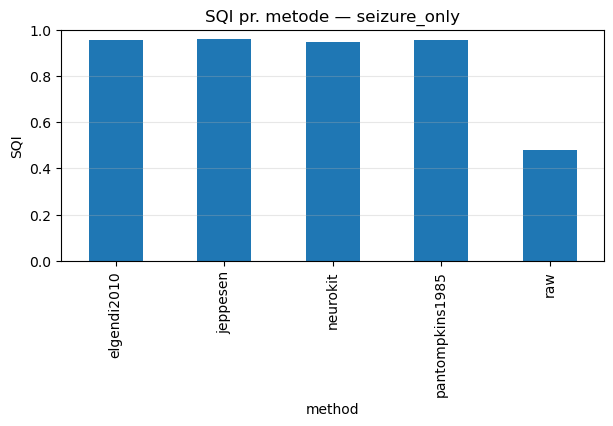

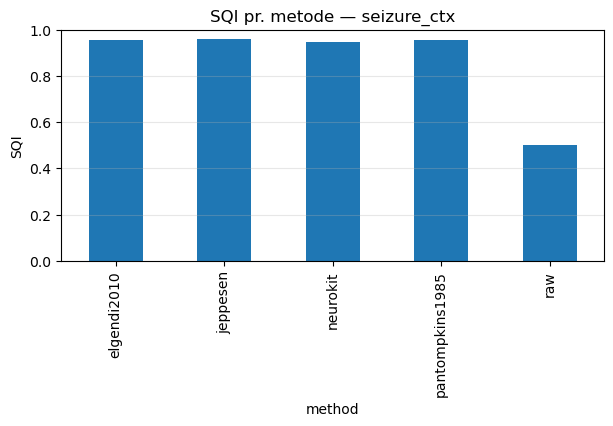

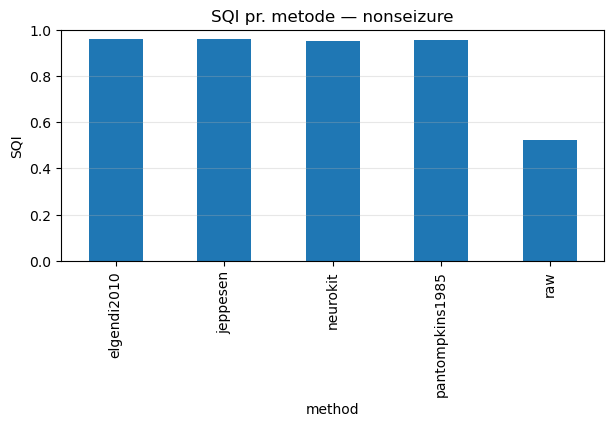

In [30]:
import matplotlib.pyplot as plt
for sn in df_event["snip"].cat.categories:
    d = df_event[df_event["snip"] == sn].set_index("method")
    if d.empty: 
        continue
    ax = d["SQI"].plot.bar(figsize=(7,3), ylim=(0,1), title=f"SQI pr. metode — {sn}")
    ax.set_ylabel("SQI"); ax.grid(True, axis="y", alpha=0.3)
    plt.show()


In [31]:
cols = ["kurtosis","skewness","spec_snr","baseline_ratio","line_ratio"]
display(df_event.pivot(index="method", columns="snip", values="kurtosis"))
display(df_event.pivot(index="method", columns="snip", values="skewness"))


snip,seizure_only,seizure_ctx,nonseizure
method,,,
elgendi2010,13.826596,17.782704,18.041558
jeppesen,19.777510,25.626335,26.192503
neurokit,19.717002,25.405732,24.127666
pantompkins1985,14.128719,18.034843,18.072636
raw,7.420792,12.164924,27.375683


snip,seizure_only,seizure_ctx,nonseizure
method,,,
elgendi2010,-1.583713,-1.798946,-1.915276
jeppesen,0.907919,1.056381,1.145053
neurokit,3.898749,4.448741,4.413708
pantompkins1985,1.413909,1.567100,1.682475
raw,1.010234,1.773250,4.431272


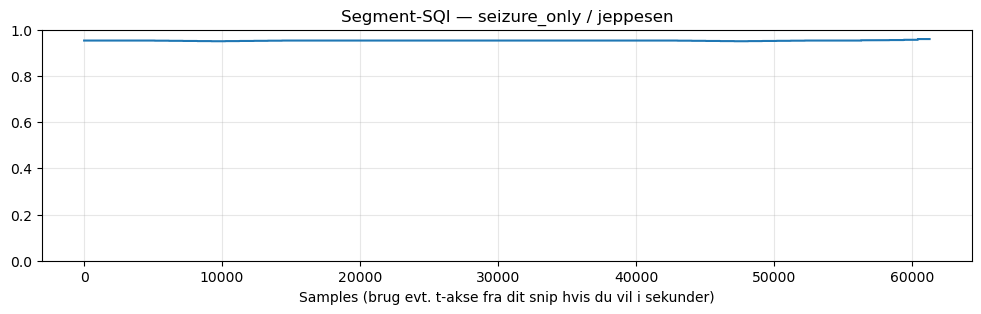

In [34]:
def plot_segment_sqi(seg_sqi, snip="seizure_ctx", method="jeppesen"):
    if (snip, method) not in seg_sqi:
        print(f"mangler {snip}-{method}")
        return
    sqi_samples, df_seg = seg_sqi[(snip, method)]
    fs_guess = 1.0  # kun til x-akse i sekunder; vi har ikke fs her, så tag fra segments DF
    if not df_seg.empty:
        fs_guess = (df_seg.loc[0,"end_s"] - df_seg.loc[0,"start_s"]) / (len(sqi_samples)/len(sqi_samples))
    t = np.arange(len(sqi_samples))  # sample-indeks
    plt.figure(figsize=(12,3))
    plt.plot(t, sqi_samples); plt.ylim(0,1)
    plt.title(f"Segment-SQI — {snip} / {method}")
    plt.xlabel("Samples (brug evt. t-akse fra dit snip hvis du vil i sekunder)")
    plt.grid(True, alpha=0.3); plt.show()

plot_segment_sqi(seg_sqi, snip="seizure_only", method="jeppesen")


In [45]:
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

BASE = Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results_Excluded_seizures_removed\Responders")  # mappe der indeholder patients/recordings/events
METHODS = ["raw", "jeppesen", "neurokit", "elgendi2010", "pantompkins1985"]
SNIP_ORDER = ["seizure_only","seizure_ctx","nonseizure"]
DATA_EXTS = (".csv", ".txt", ".tsv")


In [46]:
import re

def discover_events(base: Path):
    """Yield dicts med metadata + event_dir for hver event-mappe."""
    pattern = re.compile(r"event(\d+)_seizure_only", re.IGNORECASE)
    for p in base.rglob("*"):
        if not p.is_dir():
            continue
        names = [f.stem for f in p.iterdir() if f.is_file()]
        if any(pattern.search(n) for n in names):
            # forsøg at udtrække patient/recording id fra stien (tilpas efter din struktur)
            parts = p.parts
            patient = next((q for q in parts if q.lower().startswith("patient")), None)
            recording = next((q for q in parts if q.lower().startswith("record")), None)
            yield {
                "event_dir": p,
                "patient_id": patient or "unknown_patient",
                "recording_id": recording or "unknown_recording",
            }

events = list(discover_events(BASE))
len(events), events[:2]


(26,
 [{'event_dir': WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/LabView-Results_Excluded_seizures_removed/Responders/Patient 42/recording 1'),
   'patient_id': 'Patient 42',
   'recording_id': 'recording 1'},
  {'event_dir': WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/LabView-Results_Excluded_seizures_removed/Responders/Patient 3/recording 1'),
   'patient_id': 'Patient 3',
   'recording_id': 'recording 1'}])

In [48]:
def load_event_snips(event_dir: Path, fs_default=256.0):
    out = {}
    for key, stem in [
        ("seizure_only", "event01_seizure_only"),
        ("seizure_ctx",  "event01_seizure_ctx"),
        ("nonseizure",   "event01_nonseizure"),
    ]:
        # tillad eventXX (ikke kun 01)
        candidates = [f for f in event_dir.iterdir()
                      if f.stem.lower().startswith(stem[:-2].lower())  # "event01_seizure" -> "event"
                      and f.name.lower().endswith(key + f.suffix.lower())  # sikr korrekt snip-type
                      and f.suffix.lower() in DATA_EXTS]
        if not candidates:
            # fallback: prøv præcis stem.* i data-ender
            candidates = [f for f in event_dir.glob(f"{stem}*") if f.suffix.lower() in DATA_EXTS]
        if not candidates:
            continue
        candidates.sort(key=lambda p: (p.suffix.lower() != ".csv", p.suffix.lower()))
        path = candidates[0]
        out[key] = read_signal_file(path, fs_default)
    return out


In [49]:
def run_all_events(base: Path, methods=METHODS, seg_window_s=10.0, seg_step_s=2.0):
    rows = []
    per_event_frames = []
    seg_sqi_store = {}   # (patient, recording, event_dir, snip, method) -> (sqi_samples, df_segments)

    for meta in tqdm(discover_events(base), desc="Analyzing events"):
        snips = load_event_snips(meta["event_dir"])
        if not snips:
            continue
        df_event, seg_sqi = analyze_event_snips(snips, methods=methods,
                                                seg_window_s=seg_window_s, seg_step_s=seg_step_s)
        # tilføj metadata
        df_event["patient_id"] = meta["patient_id"]
        df_event["recording_id"] = meta["recording_id"]
        df_event["event_path"] = str(meta["event_dir"])
        per_event_frames.append(df_event)

        # gem segment-SQI (kan være stort – gem kun hvis du skal bruge det)
        for (snip, method), val in seg_sqi.items():
            seg_sqi_store[(meta["patient_id"], meta["recording_id"], str(meta["event_dir"]), snip, method)] = val

    if per_event_frames:
        df_master = pd.concat(per_event_frames, ignore_index=True)
    else:
        df_master = pd.DataFrame()

    return df_master, seg_sqi_store

df_master, seg_sqi_store = run_all_events(BASE)
df_master.head()


Analyzing events: 0it [00:00, ?it/s]

,snip,method,fs,n_samples,SQI,c_SNR,c_Baseline,c_LineNoise,c_Flatline,c_Clipping,...,kurtosis,skewness,std,median,iqr,flatline_pct,clipping_pct,patient_id,recording_id,event_path
0,seizure_only,elgendi2010,512.0,43008,0.958473,1.000000,0.999973,0.998333,0.997675,0.590774,...,7.377620,-0.111217,159.299790,-0.837415,68.349728,0.002325,0.204613,Patient 42,recording 1,E:\ML algoritme tl anfaldsdetektion vha HRV\La...
1,seizure_only,jeppesen,512.0,42840,0.959840,1.000000,0.999950,0.999999,1.000000,0.598506,...,11.068605,0.202960,74.885648,-0.016608,12.313761,0.000000,0.200747,Patient 42,recording 1,E:\ML algoritme tl anfaldsdetektion vha HRV\La...
2,seizure_only,neurokit,512.0,43008,0.830296,1.000000,0.357836,1.000000,0.997675,0.590774,...,6.362438,0.801700,233.849941,-18.388771,170.293639,0.002325,0.204613,Patient 42,recording 1,E:\ML algoritme tl anfaldsdetektion vha HRV\La...
3,seizure_only,pantompkins1985,512.0,43008,0.871253,0.806986,0.960507,0.984194,0.997675,0.590774,...,7.337736,1.509902,163.042290,-2.190330,89.980697,0.002325,0.204613,Patient 42,recording 1,E:\ML algoritme tl anfaldsdetektion vha HRV\La...
4,seizure_only,raw,512.0,43008,0.377114,0.474938,0.000000,0.856843,0.000000,0.586124,...,3.917565,0.961968,639.886447,89.560845,589.723720,13.158323,0.206938,Patient 42,recording 1,E:\ML algoritme tl anfaldsdetektion vha HRV\La...


In [54]:
OUT_DIR = Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results_Excluded_seizures_removed\Results") / "Responders_analysis"
OUT_DIR.mkdir(exist_ok=True, parents=True)

from pathlib import Path

def safe_save_table(df, out_dir: Path, stem: str, also_csv=True, compress_csv=True):
    out_dir.mkdir(parents=True, exist_ok=True)
    parquet_ok = False
    last_err = None

    # Prøv pyarrow -> fastparquet
    for engine in ("pyarrow", "fastparquet"):
        try:
            df.to_parquet(out_dir / f"{stem}.parquet", index=False, engine=engine)
            parquet_ok = True
            print(f"[OK] Skrev Parquet med engine='{engine}'")
            break
        except Exception as e:
            last_err = e

    if not parquet_ok and last_err is not None:
        print(f"[INFO] Kunne ikke skrive Parquet ({last_err}).")

    if also_csv:
        csv_path = out_dir / (f"{stem}.csv.gz" if compress_csv else f"{stem}.csv")
        df.to_csv(csv_path, index=False)
        print(f"[OK] Skrev CSV til {csv_path.name}")

# Brug:
safe_save_table(df_master, OUT_DIR, "ecg_event_metrics", also_csv=True, compress_csv=True)



[OK] Skrev Parquet med engine='fastparquet'
[OK] Skrev CSV til ecg_event_metrics.csv.gz


In [55]:
def agg_summary(df, metric="SQI"):
    grp = df.groupby(["snip","method"], observed=True)[metric]
    out = grp.agg(["mean","std","median","count"]).reset_index()
    # sortér pænt
    out["snip"] = pd.Categorical(out["snip"], categories=SNIP_ORDER, ordered=True)
    return out.sort_values(["snip","mean"], ascending=[True, False])

summary_sqi = agg_summary(df_master, metric="SQI")
summary_sqi


,snip,method,mean,std,median,count
1,seizure_only,jeppesen,0.954514,0.012774,0.959314,24
0,seizure_only,elgendi2010,0.944482,0.031105,0.958417,24
2,seizure_only,neurokit,0.890803,0.061659,0.902223,24
3,seizure_only,pantompkins1985,0.868878,0.090183,0.878805,24
4,seizure_only,raw,0.414566,0.131283,0.461740,24
6,seizure_ctx,jeppesen,0.957073,0.004717,0.959254,26
5,seizure_ctx,elgendi2010,0.951723,0.016994,0.958796,26
8,seizure_ctx,pantompkins1985,0.877907,0.072876,0.883327,26
7,seizure_ctx,neurokit,0.870473,0.059959,0.888126,26
9,seizure_ctx,raw,0.428330,0.102103,0.457129,26


In [56]:
def paired_delta(df, snip="seizure_ctx", base="jeppesen", others=("neurokit","elgendi2010","pantompkins1985"), metric="SQI"):
    d = df[df["snip"]==snip].copy()
    keycols = ["patient_id","recording_id","event_path"]
    # pivot til brede kolonner per metode
    wide = d.pivot_table(index=keycols, columns="method", values=metric, aggfunc="mean")
    out_rows=[]
    for m in others:
        if m in wide and base in wide:
            delta = wide[m] - wide[base]
            out_rows.append(pd.DataFrame({
                "snip":[snip]*len(delta),
                "compare": [f"{m} - {base}"]*len(delta),
                "delta": delta.values
            }))
    return pd.concat(out_rows, ignore_index=True) if out_rows else pd.DataFrame()

df_deltas = pd.concat([
    paired_delta(df_master, snip=sn, base="jeppesen", others=["neurokit","elgendi2010","pantompkins1985"], metric="SQI")
    for sn in SNIP_ORDER
], ignore_index=True)

# sammendrag pr. sammenligning
df_deltas.groupby(["snip","compare"])["delta"].agg(["mean","std","median","count"])


mean       std    median  count
snip         compare                                                        
nonseizure   elgendi2010 - jeppesen     -0.000262  0.000572 -0.000286     26
             neurokit - jeppesen        -0.052563  0.062241 -0.030661     26
             pantompkins1985 - jeppesen -0.040342  0.048029 -0.013609     26
seizure_ctx  elgendi2010 - jeppesen     -0.005350  0.012738 -0.000384     26
             neurokit - jeppesen        -0.086600  0.059811 -0.063155     26
             pantompkins1985 - jeppesen -0.079165  0.069372 -0.076036     26
seizure_only elgendi2010 - jeppesen     -0.010031  0.020391 -0.000627     24
             neurokit - jeppesen        -0.063710  0.062509 -0.041614     24
             pantompkins1985 - jeppesen -0.085635  0.082599 -0.080770     24

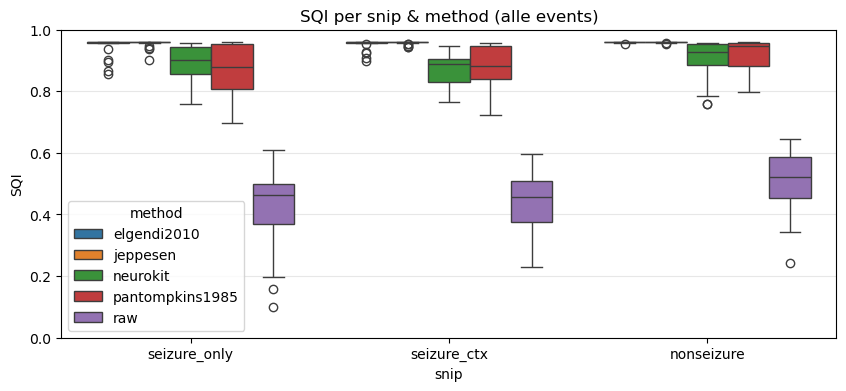

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
sns.boxplot(data=df_master, x="snip", y="SQI", hue="method", order=SNIP_ORDER)
plt.ylim(0,1); plt.grid(True, axis="y", alpha=0.3)
plt.title("SQI per snip & method (alle events)")
plt.show()


In [58]:
pv = df_master.pivot_table(index="method", columns="snip", values="SQI", aggfunc="mean")
pv = pv[SNIP_ORDER]
pv


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_21760\4061004273.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pv = df_master.pivot_table(index="method", columns="snip", values="SQI", aggfunc="mean")


snip,seizure_only,seizure_ctx,nonseizure
method,,,
elgendi2010,0.944482,0.951723,0.958511
jeppesen,0.954514,0.957073,0.958772
neurokit,0.890803,0.870473,0.906210
pantompkins1985,0.868878,0.877907,0.918430
raw,0.414566,0.428330,0.505294


In [59]:
def seizure_nonseizure_delta(df, metric="SQI"):
    key = ["patient_id","recording_id","event_path","method"]
    pv = df.pivot_table(index=key, columns="snip", values=metric, aggfunc="mean")
    pv = pv.reindex(columns=SNIP_ORDER)
    pv["delta_seizure_vs_non"] = pv["seizure_ctx"] - pv["nonseizure"]
    return pv.reset_index()

df_seiz_vs_non = seizure_nonseizure_delta(df_master, metric="SQI")
df_seiz_vs_non.groupby("method")["delta_seizure_vs_non"].agg(["mean","std","median","count"])


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_21760\2036304478.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pv = df.pivot_table(index=key, columns="snip", values=metric, aggfunc="mean")


,mean,std,median,count
method,,,,
elgendi2010,-0.006788,0.017125,-0.000004,26
jeppesen,-0.001700,0.004737,0.000000,26
neurokit,-0.035737,0.046520,-0.022171,26
pantompkins1985,-0.040523,0.071191,-0.005363,26
raw,-0.076964,0.093305,-0.087555,26


In [63]:
def report_patient(df, patient_id):
    d = df[df["patient_id"]==patient_id]
    if d.empty:
        print("Ingen data for", patient_id); return
    print("Events:", d["event_path"].nunique(), "| Recordings:", d["recording_id"].nunique())
    display(agg_summary(d, metric="SQI"))
    display(agg_summary(d, metric="spec_snr"))

report_patient(df_master, patient_id="Patient 5")


Events: 1 | Recordings: 1


,snip,method,mean,std,median,count
1,seizure_only,jeppesen,0.959032,NaN,0.959032,1
0,seizure_only,elgendi2010,0.957394,NaN,0.957394,1
3,seizure_only,pantompkins1985,0.954861,NaN,0.954861,1
2,seizure_only,neurokit,0.945109,NaN,0.945109,1
4,seizure_only,raw,0.478907,NaN,0.478907,1
6,seizure_ctx,jeppesen,0.958425,NaN,0.958425,1
5,seizure_ctx,elgendi2010,0.956723,NaN,0.956723,1
8,seizure_ctx,pantompkins1985,0.954372,NaN,0.954372,1
7,seizure_ctx,neurokit,0.946815,NaN,0.946815,1
9,seizure_ctx,raw,0.501644,NaN,0.501644,1


,snip,method,mean,std,median,count
2,seizure_only,neurokit,108527.213110,NaN,108527.213110,1
0,seizure_only,elgendi2010,15115.581420,NaN,15115.581420,1
1,seizure_only,jeppesen,10330.746716,NaN,10330.746716,1
3,seizure_only,pantompkins1985,2042.094079,NaN,2042.094079,1
4,seizure_only,raw,116.206139,NaN,116.206139,1
7,seizure_ctx,neurokit,150946.492655,NaN,150946.492655,1
5,seizure_ctx,elgendi2010,18992.969387,NaN,18992.969387,1
6,seizure_ctx,jeppesen,12931.616373,NaN,12931.616373,1
8,seizure_ctx,pantompkins1985,2664.345490,NaN,2664.345490,1
9,seizure_ctx,raw,164.960725,NaN,164.960725,1
